# Model Report

In [1]:
import logging
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import sampling_pymc3_models_cli as sampling
from src.data_processing import common as dphelp
from src.loggers import set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models import configuration
from src.models.speclet_pipeline_test_model import SpecletTestModel
from src.plot.color_pal import SeabornColor
from src.project_enums import ModelFitMethod

In [2]:
notebook_tic = time()

set_console_handler_level(logging.WARNING)
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

path_prefix = Path("..", "..")

Parameters for papermill:

- `CONFIG_PATH`: path to configuration file
- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
CONFIG_PATH = "models/model-configs.yaml"
MODEL_NAME = "sp7-default"
FIT_METHOD = "ADVI"
ROOT_CACHE_DIR = "models/"

In [5]:
# Check the fit method is recognized.
assert ModelFitMethod(FIT_METHOD) in ModelFitMethod

In [6]:
speclet_model = configuration.get_config_and_instantiate_model(
    path_prefix / CONFIG_PATH,
    name=MODEL_NAME,
    root_cache_dir=path_prefix / ROOT_CACHE_DIR,
)

speclet_model.build_model()

[07/12/21 09:28:06] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626096486.1357365-884934;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626096486.1479192-2284;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

In [7]:
if FIT_METHOD == "ADVI":
    model_az, advi_approx = speclet_model.load_advi_cache()
else:
    model_az = speclet_model.load_mcmc_cache()

### Data

In [8]:
data = speclet_model.data_manager.get_data()
data.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,CTTGTTAGATAATGGAACT,LS513_c903R1,-1.100620,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,True,2,157544604,...,0,NaN,NaN,NaN,False,0.964254,colorectal,primary,True,63.0
1,CTTGTTAGATAATGGAACT,CL11_c903R1,-0.572939,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,True,2,157544604,...,0,NaN,NaN,NaN,False,1.004888,colorectal,primary,True,NaN
2,CTTGTTAGATAATGGAACT,HT29_c904R1,0.054573,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,True,2,157544604,...,0,NaN,NaN,NaN,False,1.014253,colorectal,primary,False,44.0
3,CTTGTTAGATAATGGAACT,SNUC1_c903R4,0.700923,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,True,2,157544604,...,0,NaN,NaN,NaN,False,0.946028,colorectal,metastasis,True,71.0
4,CTTGTTAGATAATGGAACT,KM12_c908R1_100,-1.123352,CRISPR_C6596666.sample,chr2_157544604_-,ACVR1C,sanger,True,2,157544604,...,0,NaN,NaN,NaN,False,1.048861,colorectal,primary,NaN,NaN


### Cached model fit

In [9]:
print(speclet_model.model)

      μ_μ_μ_a ~ Normal
σ_μ_μ_a_log__ ~ TransformedDistribution
σ_σ_μ_a_log__ ~ TransformedDistribution
  σ_μ_a_log__ ~ TransformedDistribution
  σ_σ_a_log__ ~ TransformedDistribution
    σ_a_log__ ~ TransformedDistribution
        μ_μ_a ~ Normal
          μ_a ~ Normal
            a ~ Normal
      σ_log__ ~ TransformedDistribution
      σ_μ_μ_a ~ HalfNormal
      σ_σ_μ_a ~ HalfNormal
        σ_μ_a ~ HalfNormal
        σ_σ_a ~ HalfNormal
          σ_a ~ HalfNormal
            μ ~ Deterministic
            σ ~ HalfNormal
          lfc ~ Normal


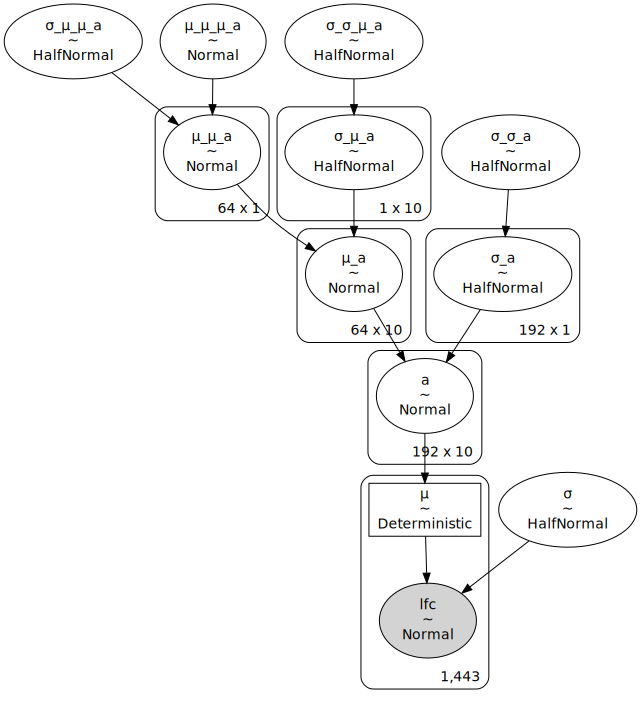

In [10]:
pm.model_to_graphviz(speclet_model.model)

## Fit diagnostics

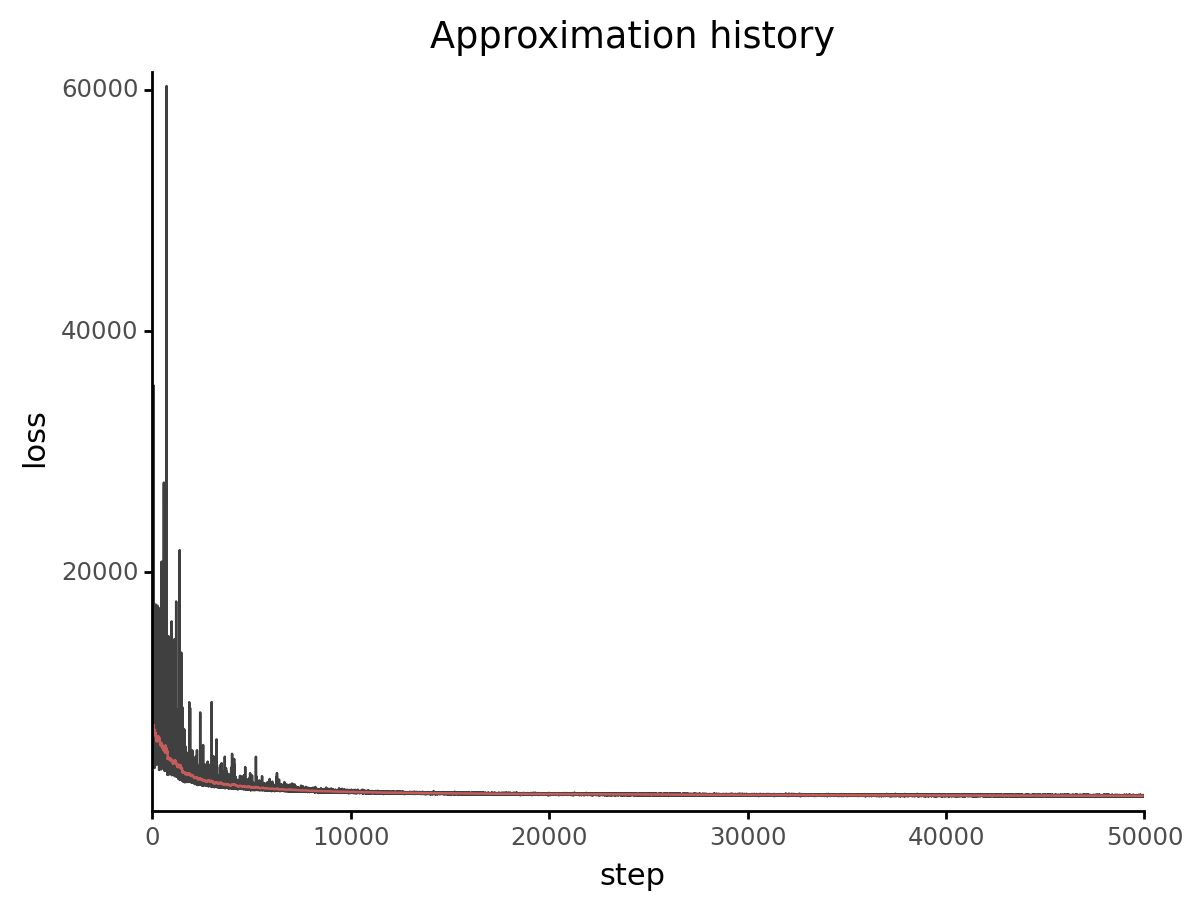

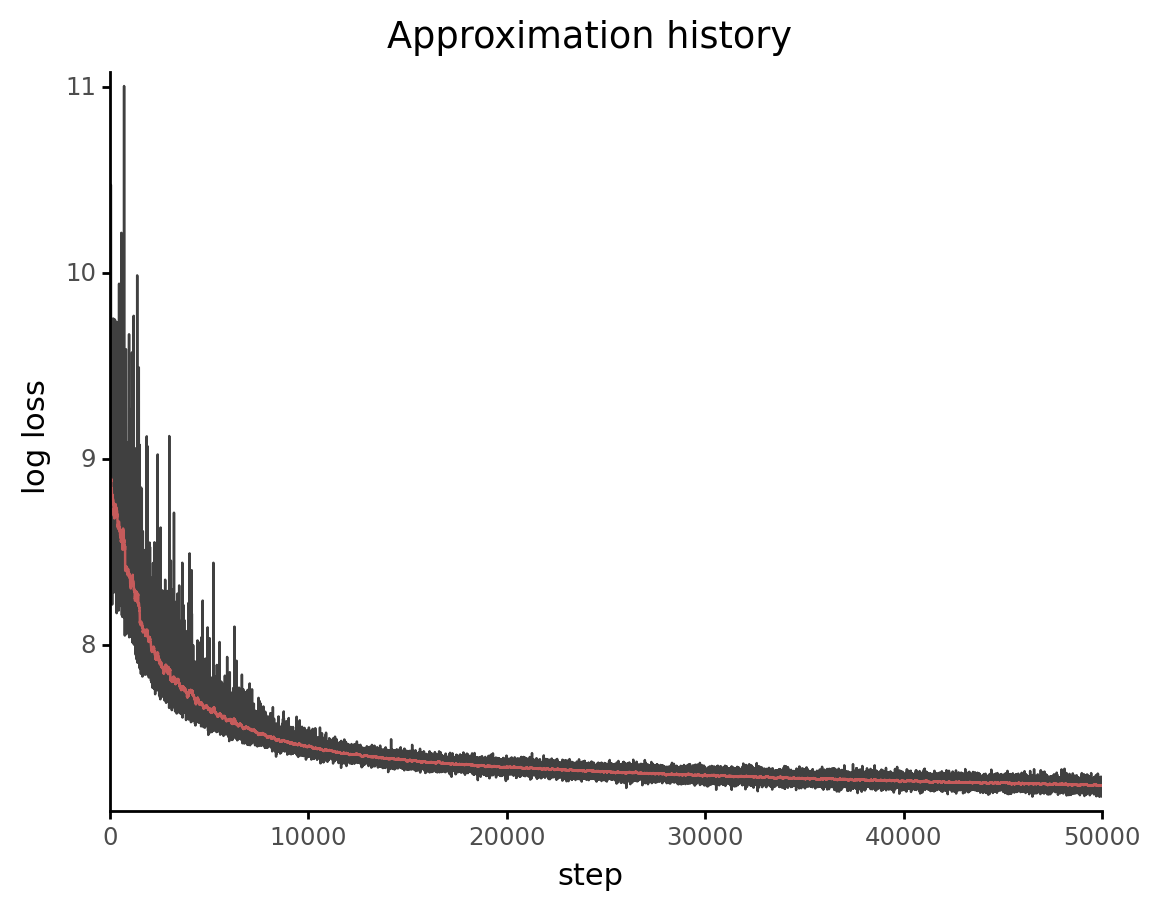

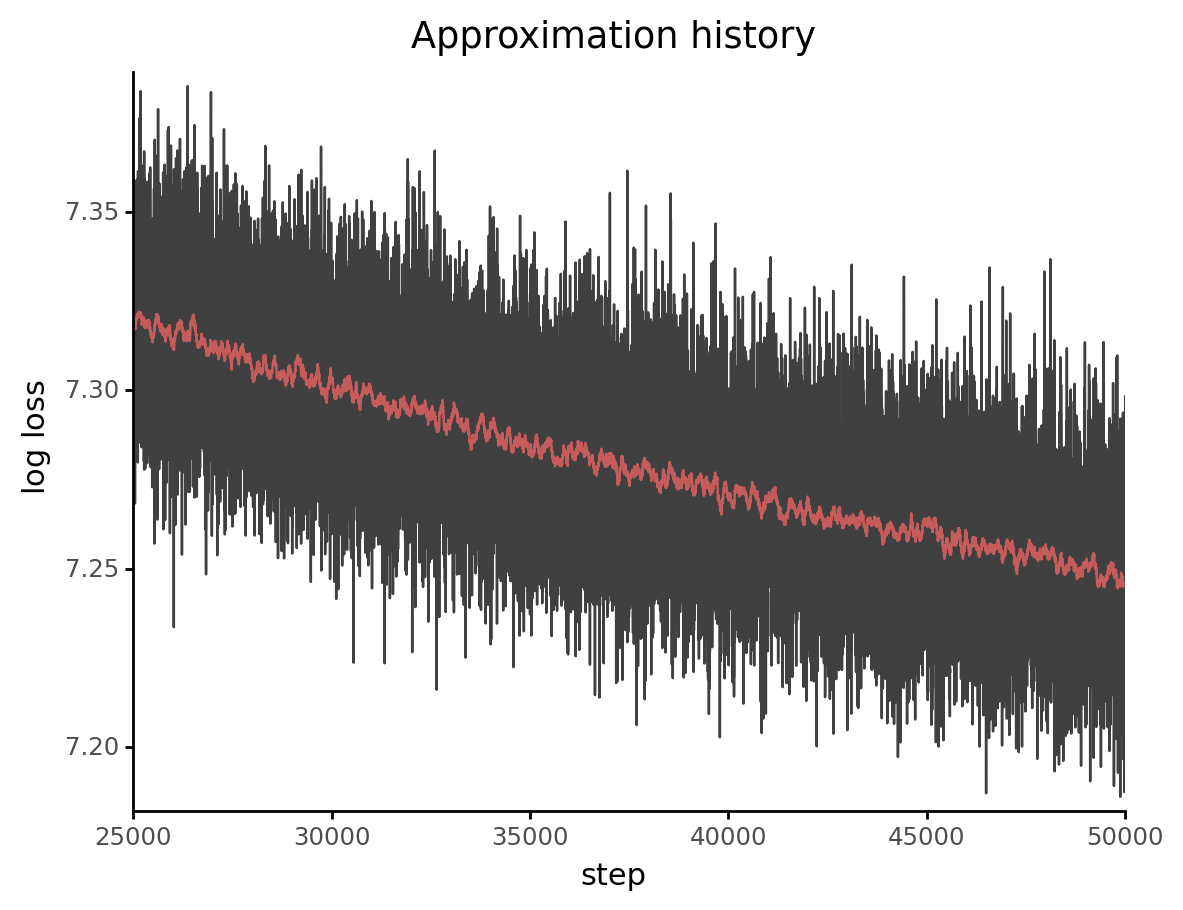

In [11]:
if FIT_METHOD == "ADVI":
    pmanal.plot_vi_hist(advi_approx).draw()
    pmanal.plot_vi_hist(advi_approx, y_log=True).draw()
    pmanal.plot_vi_hist(advi_approx, y_log=True, x_start=0.5).draw()
    plt.show()
else:
    print("R-HAT")
    print(az.rhat(model_az))
    print("=" * 60)
    print("BFMI")
    print(az.bfmi(model_az))

## Model parameters

In [12]:
def check_shape(trace: np.ndarray) -> np.ndarray:
    if len(trace.shape) == 1:
        return trace[:, None]
    return trace


def add_hdi(p: gg.ggplot, values: np.ndarray, color: str) -> gg.ggplot:
    m = np.mean(values)
    hdi = az.hdi(values, hdi_prob=0.89).flatten()
    p = (
        p
        + gg.geom_vline(xintercept=m, color=color)
        + gg.geom_vline(xintercept=hdi, color=color, linetype="--")
    )
    return p


def variable_distribution_plot(var, trace: np.ndarray, max_plot=20000) -> gg.ggplot:
    trace = check_shape(trace)

    # Sample 25% of the trace.
    d = pd.DataFrame(trace).melt().assign(variable=lambda d: d.variable.astype("str"))
    d_summaries = d.groupby(["variable"])["value"].mean().reset_index(drop=False)

    if d.shape[0] > max_plot:
        d = d.sample(n=max_plot)
    else:
        d = d.sample(frac=0.2)

    p = (
        gg.ggplot(d, gg.aes(x="value"))
        + gg.geom_density(alpha=0.1)
        + gg.geom_vline(xintercept=0, color="black", size=0.7, alpha=0.7, linetype="--")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(legend_position="none", figure_size=(6.5, 3))
        + gg.labs(x="posterior", y="density", title=f"Posterior distirbution of {var}")
    )

    c = SeabornColor.BLUE

    if len(d_summaries) > 1:
        p = p + gg.geom_rug(
            data=d_summaries, sides="b", alpha=0.5, color=c, length=0.08
        )
    else:
        p = add_hdi(p, trace.flatten(), color=c)

    return p

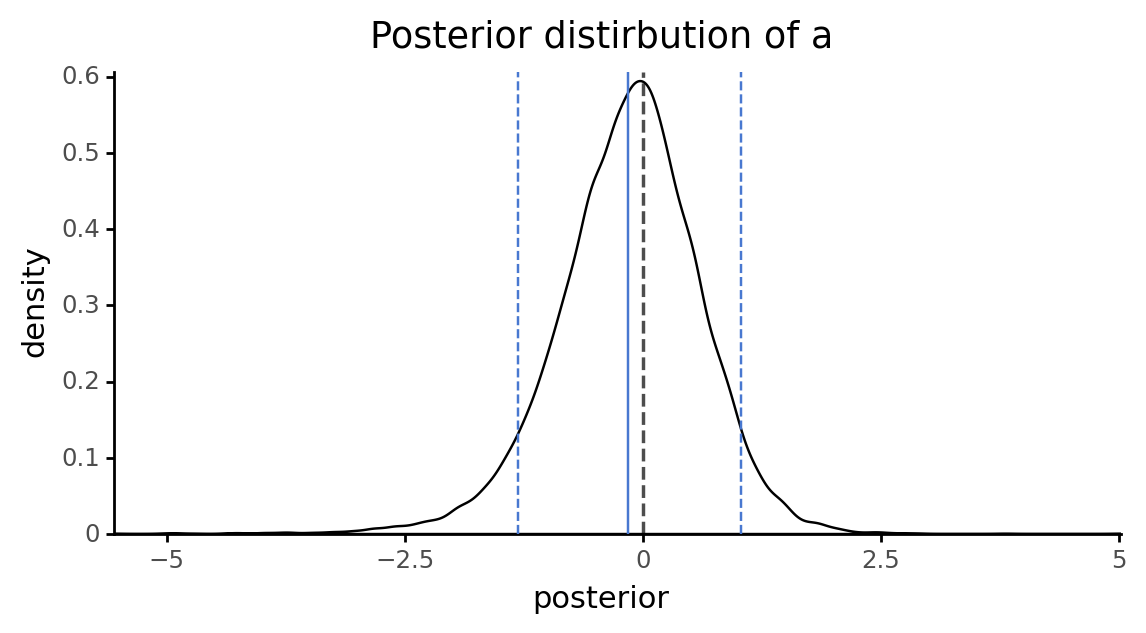

<ggplot: (2946449081263)>


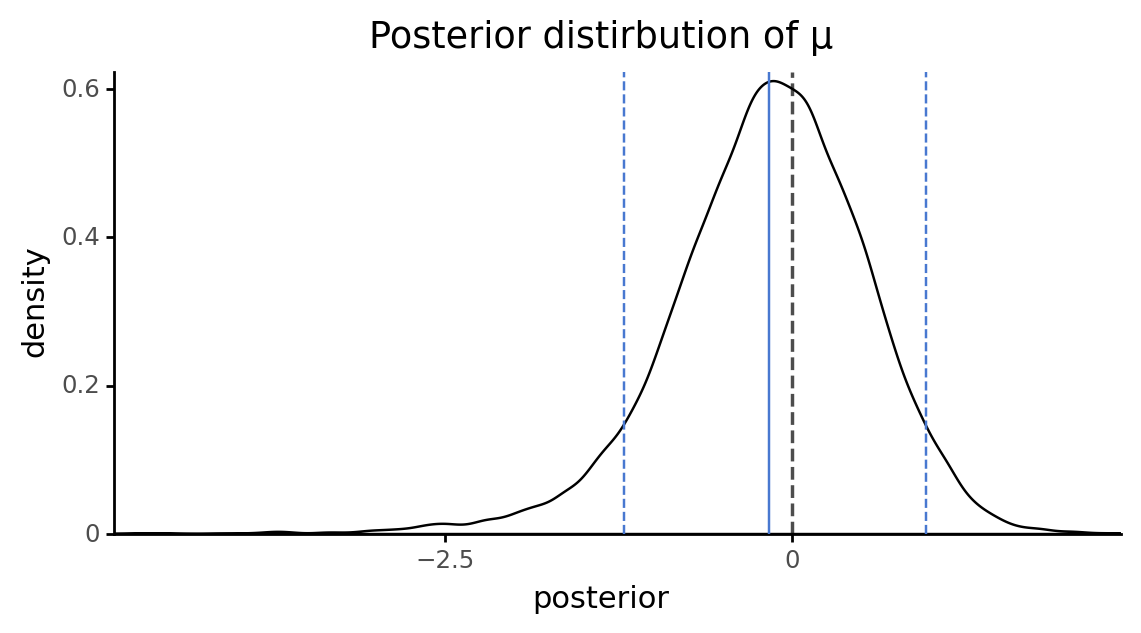

<ggplot: (2946449052347)>


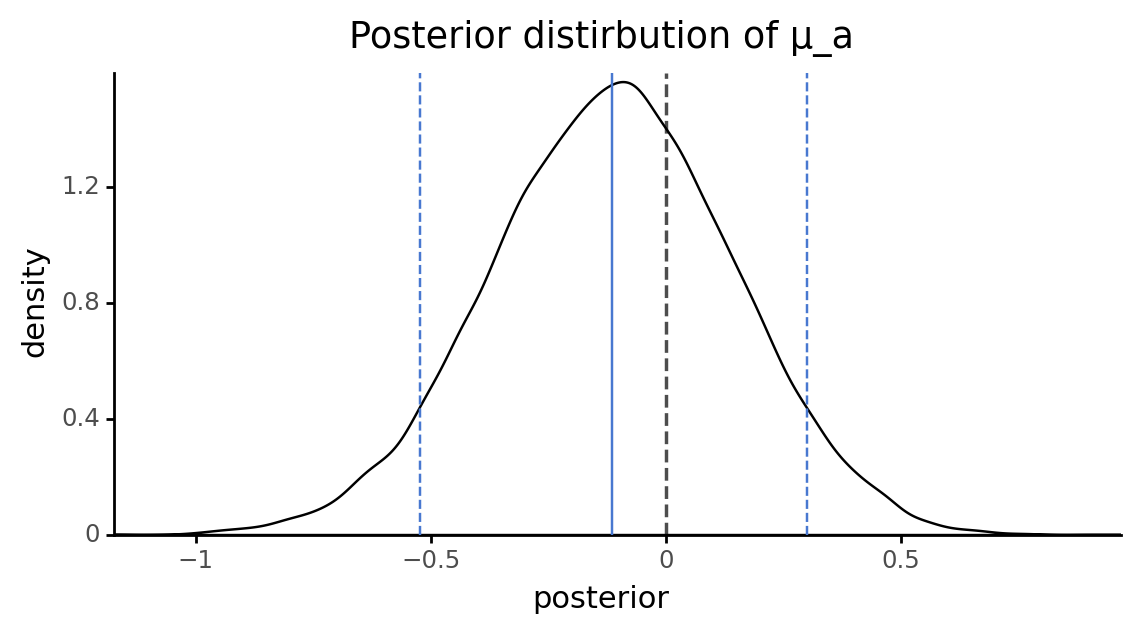

<ggplot: (2946449057485)>


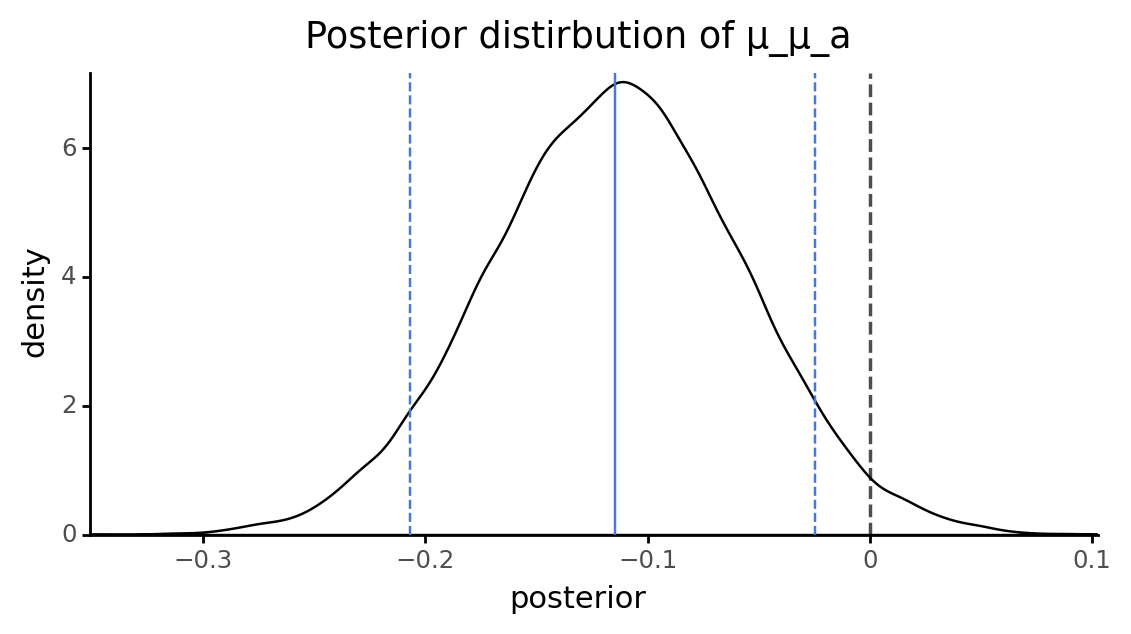

<ggplot: (2946449081637)>


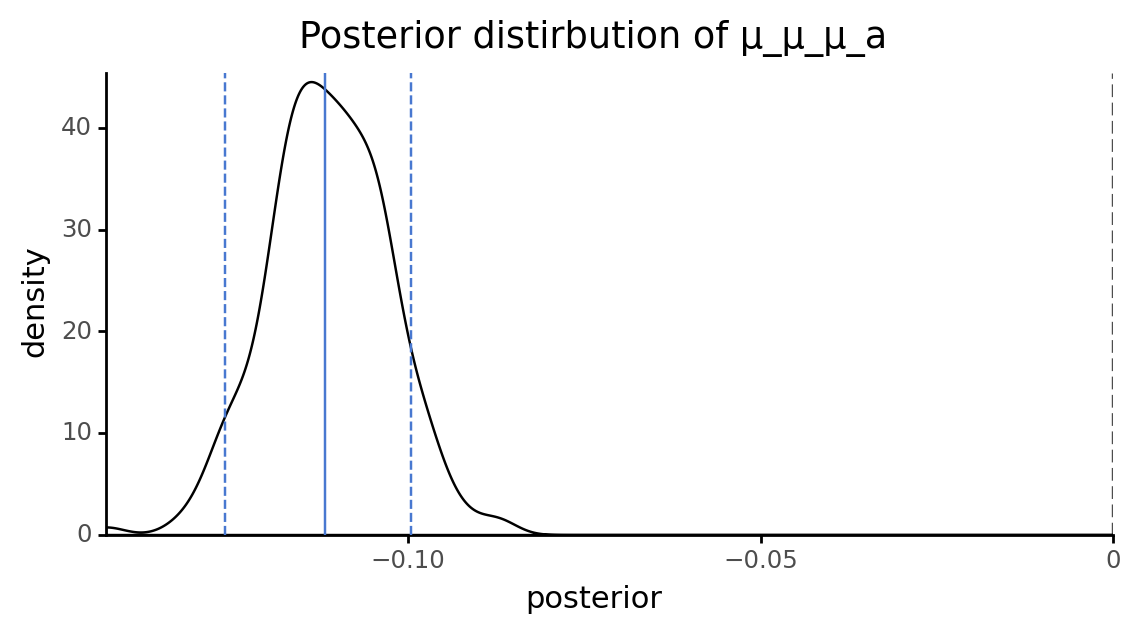

<ggplot: (2946449074258)>


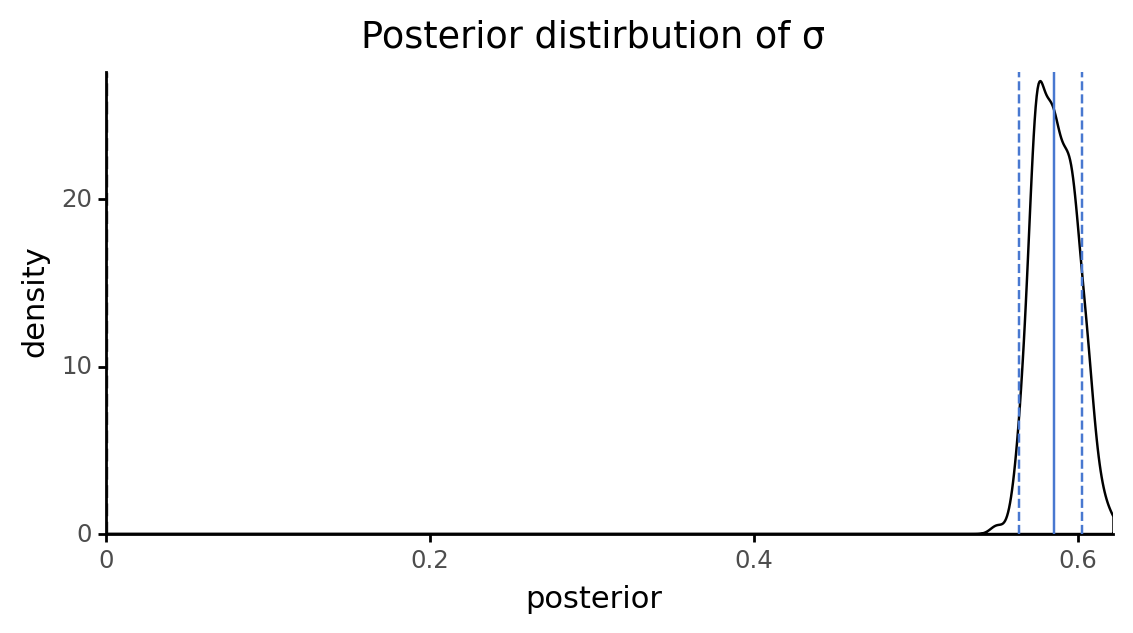

<ggplot: (2946449078574)>


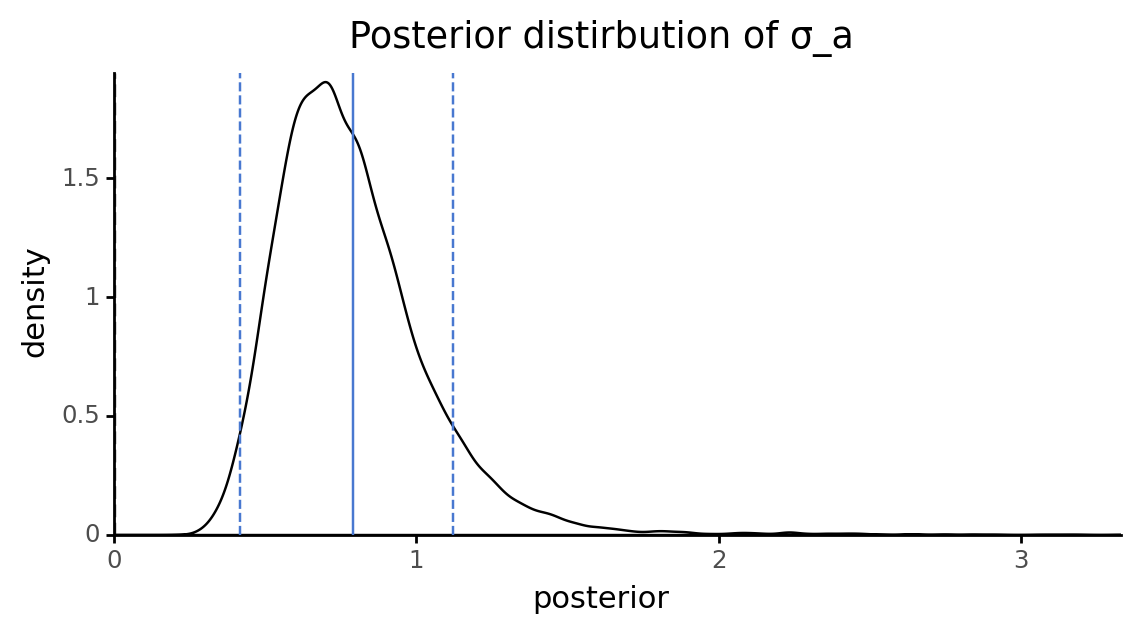

<ggplot: (2946457524471)>


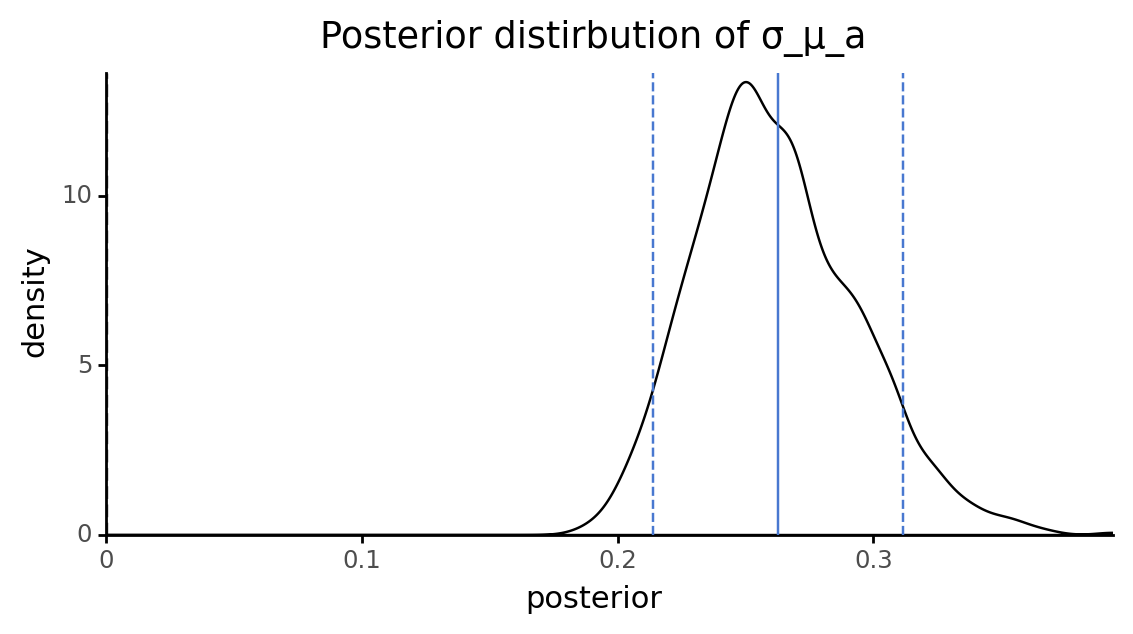

<ggplot: (2946449084224)>


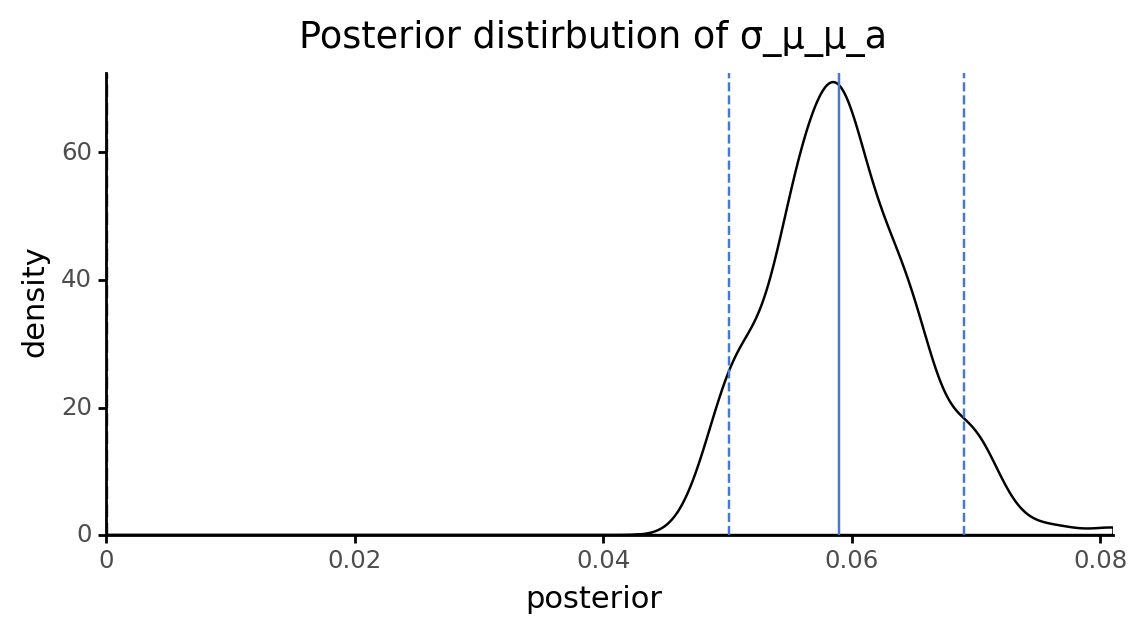

<ggplot: (2946449079164)>


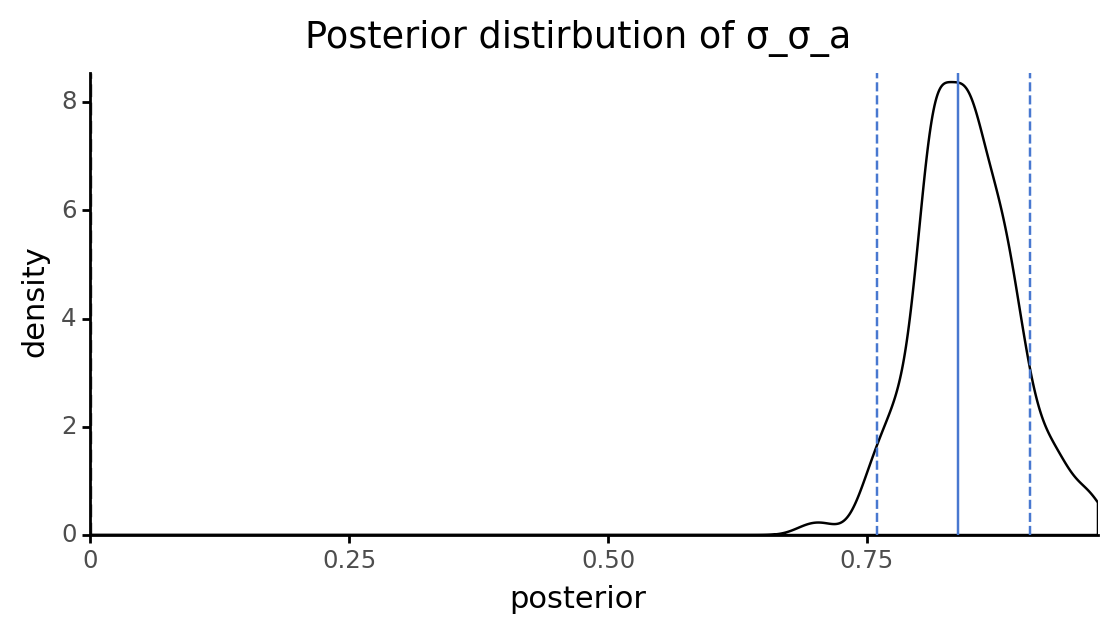

<ggplot: (2946449084311)>


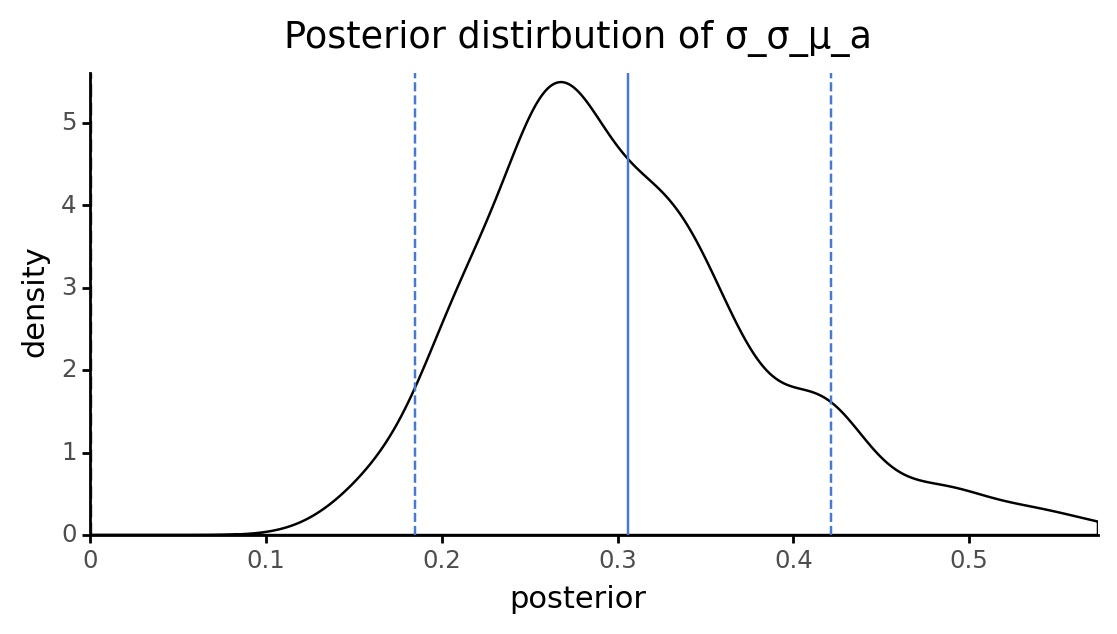

<ggplot: (2946457108005)>


In [13]:
ignore_vars = "μ"
vars_to_inspect = model_az.posterior.keys()
vars_to_inspect = [v for v in vars_to_inspect if not "log" in v]
vars_to_inspect.sort()

for var in vars_to_inspect:
    trace = model_az.posterior[var]
    if trace.shape[1] == data.shape[0]:
        # Do not plot the final deterministic mean (usually "μ").
        continue
    try:
        print(variable_distribution_plot(var, model_az.posterior[var].values.flatten()))
    except Exception as err:
        print(f"Skipping variable '{var}'.")
        print(err)

In [14]:
if isinstance(speclet_model, SpecletTestModel):
    raise KeyboardInterrupt()

## Model predictions

In [15]:
predictions = model_az.posterior_predictive
pred_summary = pmanal.summarize_posterior_predictions(
    predictions["lfc"].values,
    merge_with=data,
    calc_error=True,
    observed_y="lfc",
)
pred_summary.head()

/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/daab5ac5/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,...,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age,error
0,-0.704929,-1.929915,0.598241,CTTGTTAGATAATGGAACT,LS513_c903R1,-1.100620,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,...,NaN,NaN,NaN,False,0.964254,colorectal,primary,True,63.0,-0.395692
1,-0.320309,-1.515630,1.041401,CTTGTTAGATAATGGAACT,CL11_c903R1,-0.572939,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,...,NaN,NaN,NaN,False,1.004888,colorectal,primary,True,NaN,-0.252630
2,0.055424,-1.186957,1.360440,CTTGTTAGATAATGGAACT,HT29_c904R1,0.054573,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,...,NaN,NaN,NaN,False,1.014253,colorectal,primary,False,44.0,-0.000851
3,0.338752,-0.958467,1.558499,CTTGTTAGATAATGGAACT,SNUC1_c903R4,0.700923,ERS717283.plasmid,chr2_157544604_-,ACVR1C,sanger,...,NaN,NaN,NaN,False,0.946028,colorectal,metastasis,True,71.0,0.362172
4,-0.654260,-1.827918,0.647912,CTTGTTAGATAATGGAACT,KM12_c908R1_100,-1.123352,CRISPR_C6596666.sample,chr2_157544604_-,ACVR1C,sanger,...,NaN,NaN,NaN,False,1.048861,colorectal,primary,NaN,NaN,-0.469092


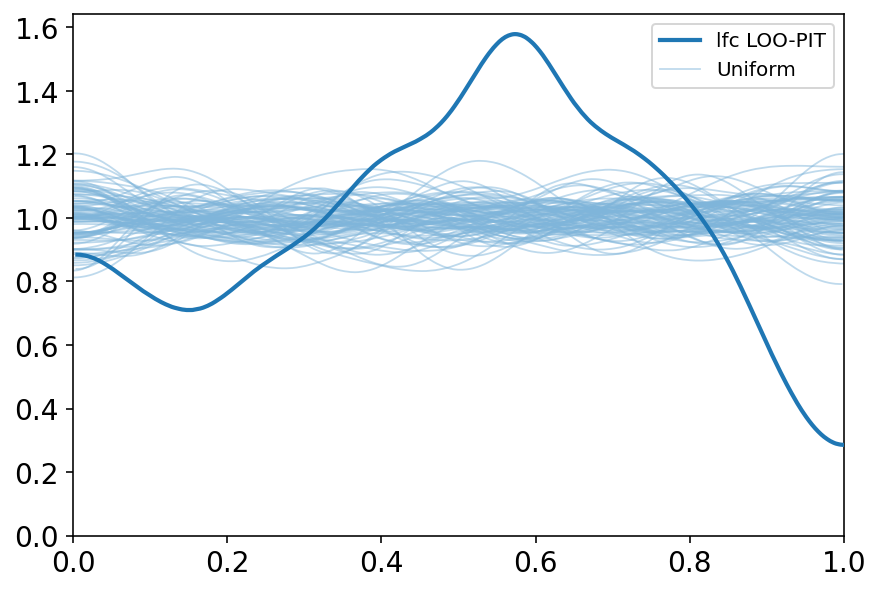

In [16]:
try:
    az.plot_loo_pit(model_az, y="lfc")
except Exception as e:
    print(e)

In [17]:
model_loo = az.loo(model_az, pointwise=True)
print(model_loo)

Computed from 1000 by 1443 log-likelihood matrix

         Estimate       SE
elpd_loo -2066.06    23.02
p_loo     1010.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       90    6.2%
 (0.5, 0.7]   (ok)        417   28.9%
   (0.7, 1]   (bad)       715   49.5%
   (1, Inf)   (very bad)  221   15.3%



/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/daab5ac5/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

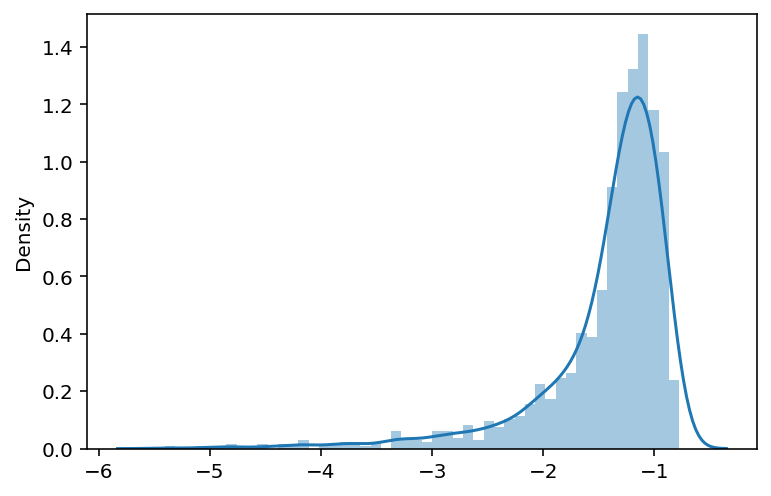

In [18]:
sns.distplot(model_loo.loo_i.values);

In [19]:
pred_summary["loo"] = model_loo.loo_i.values

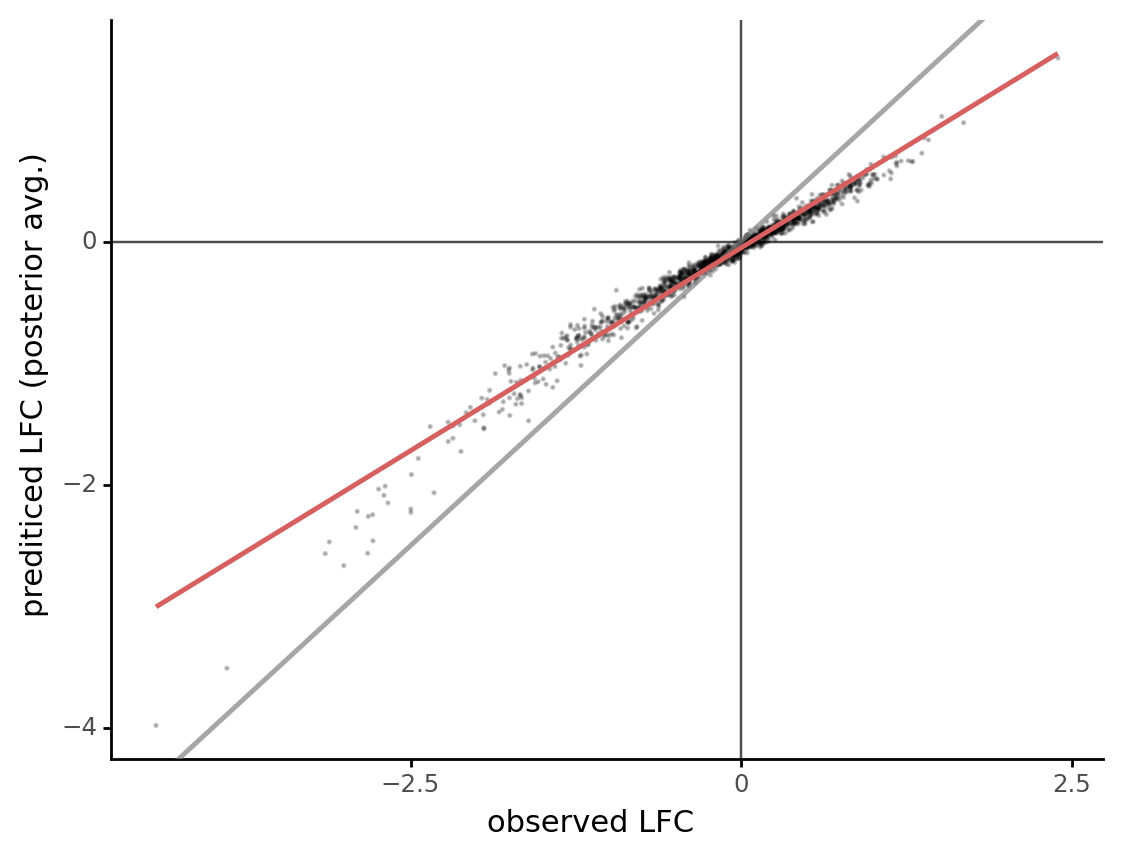

<ggplot: (2946459381071)>

In [20]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.geom_abline(slope=1, intercept=0, size=1, alpha=0.7, color="grey")
    + gg.geom_smooth(method="glm", color=SeabornColor.RED, size=1, alpha=0.7, se=False)
    + gg.labs(x="observed LFC", y="prediticed LFC (posterior avg.)")
)

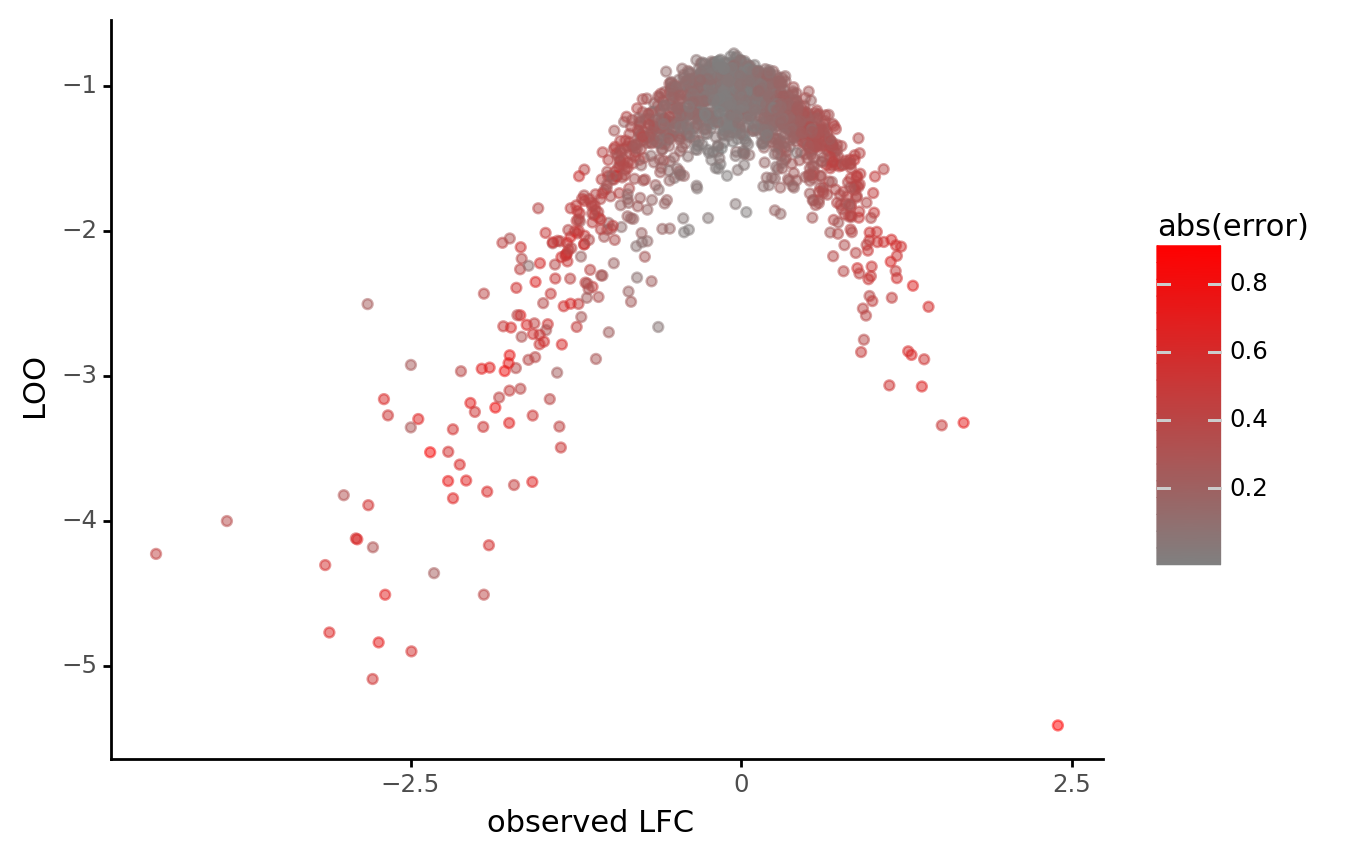

<ggplot: (2946437979576)>

In [21]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="loo"))
    + gg.geom_point(gg.aes(color="np.abs(error)"), alpha=0.5)
    + gg.scale_color_gradient(low="grey", high="red")
    + gg.theme()
    + gg.labs(x="observed LFC", y="LOO", color="abs(error)")
)

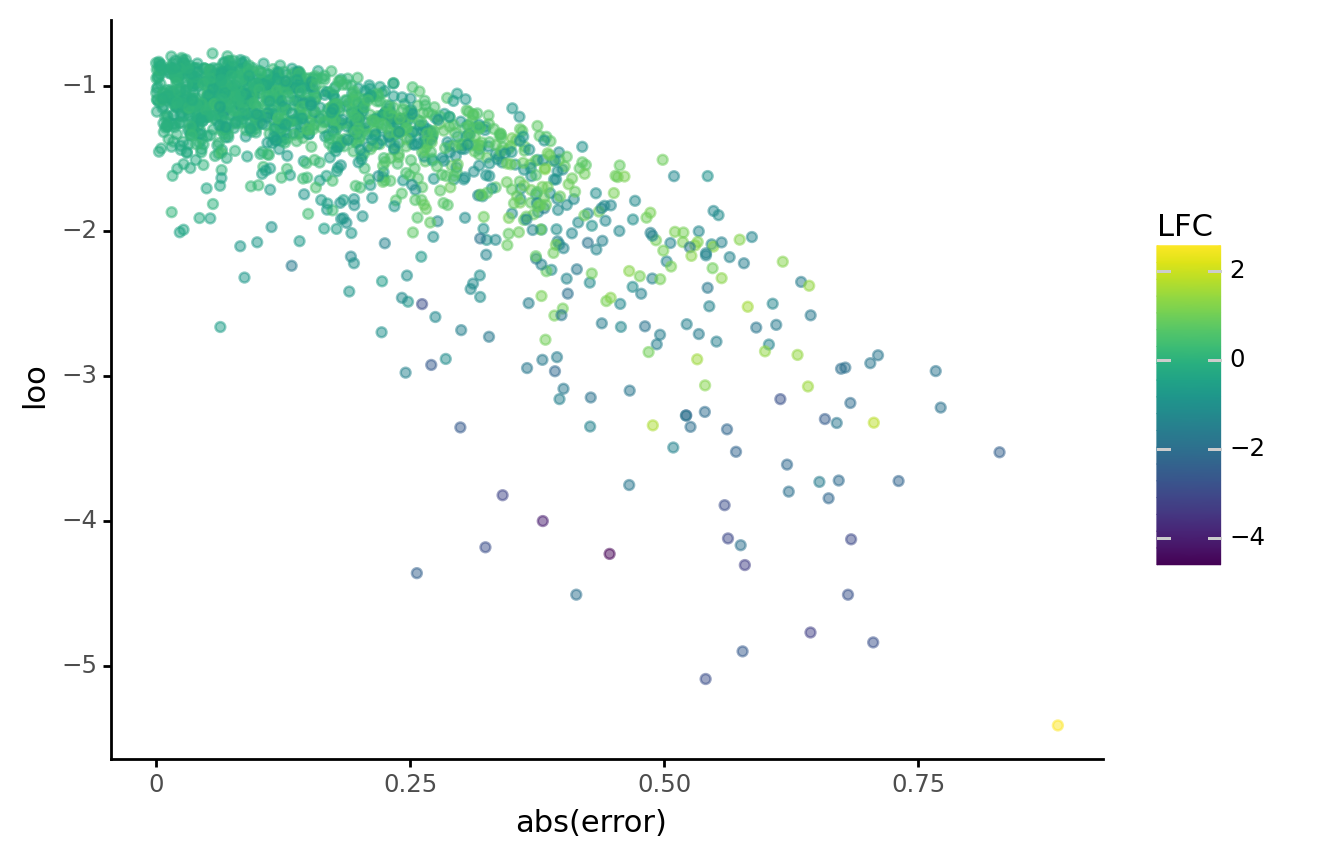

<ggplot: (2946459381092)>

In [22]:
(
    gg.ggplot(pred_summary, gg.aes(x="np.abs(error)", y="loo"))
    + gg.geom_point(gg.aes(color="lfc"), alpha=0.5)
    + gg.labs(x="abs(error)", y="loo", color="LFC")
)

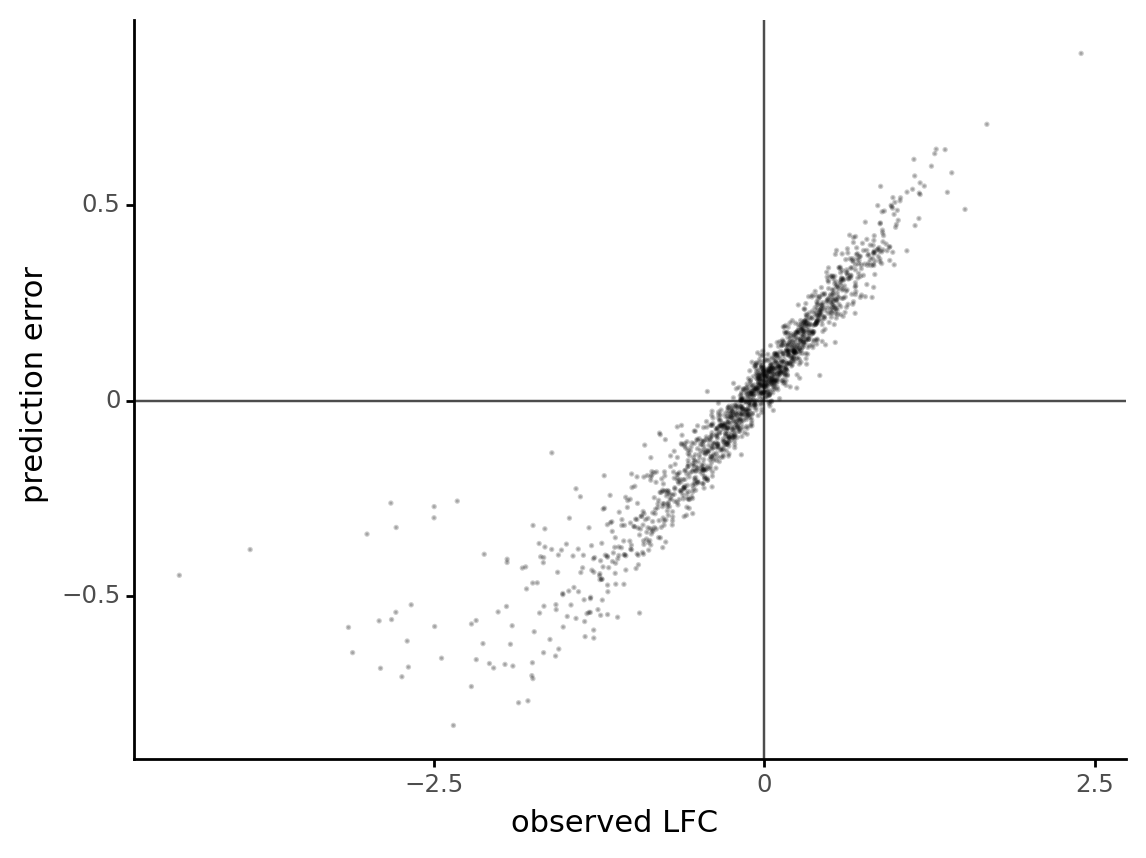

<ggplot: (2946452290780)>

In [23]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="observed LFC", y="prediction error")
)

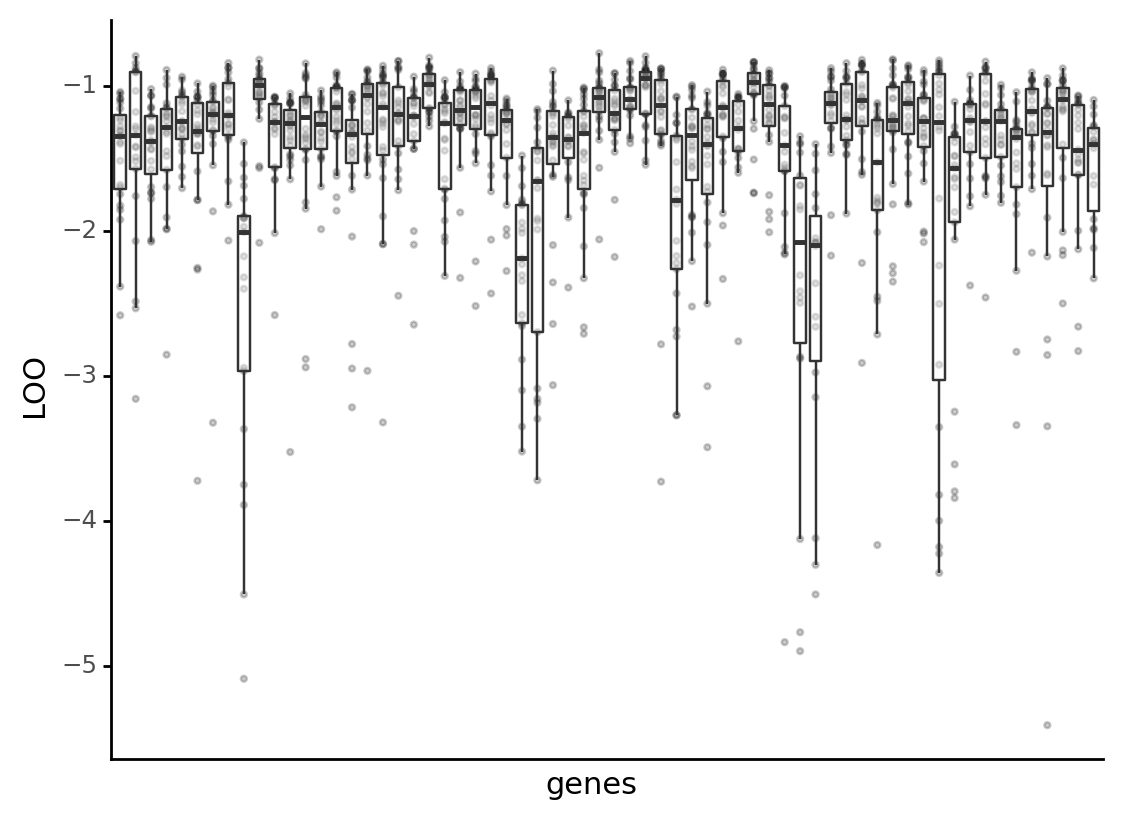

<ggplot: (2946452305875)>

In [24]:
(
    gg.ggplot(pred_summary, gg.aes(x="hugo_symbol", y="loo"))
    + gg.geom_point(alpha=0.2, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(axis_text_x=gg.element_blank(), axis_ticks_major_x=gg.element_blank())
    + gg.labs(x="genes", y="LOO")
)

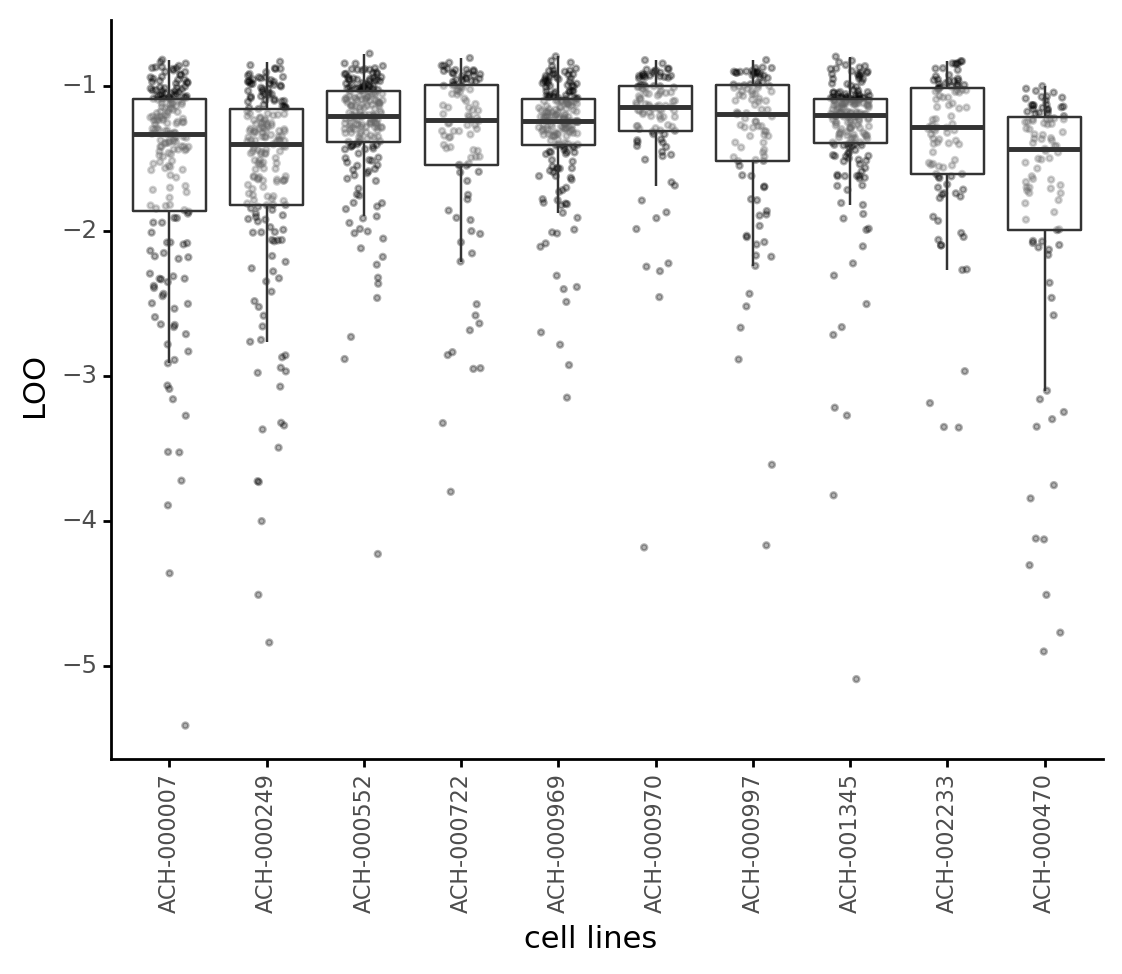

<ggplot: (2946449562609)>

In [25]:
(
    gg.ggplot(pred_summary, gg.aes(x="depmap_id", y="loo"))
    + gg.geom_jitter(width=0.2, alpha=0.3, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=8),
    )
    + gg.labs(x="cell lines", y="LOO")
)

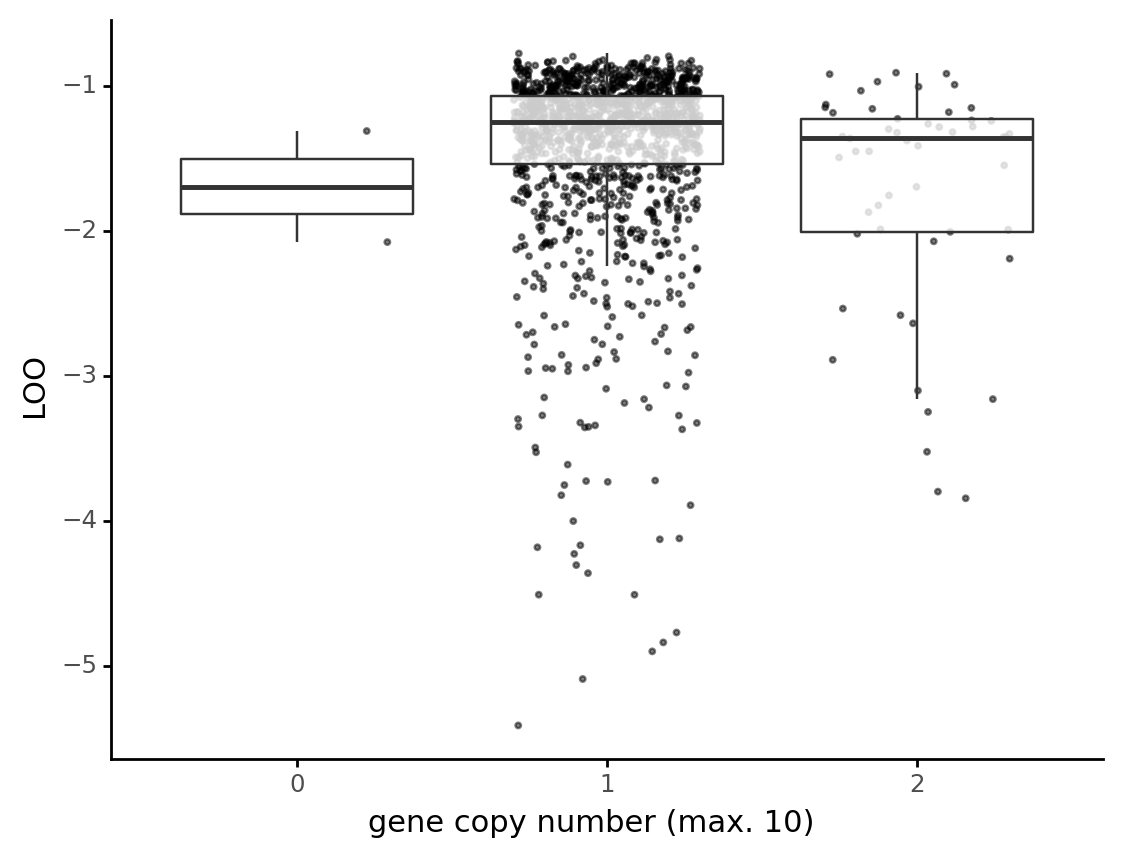

<ggplot: (2946449562522)>

In [26]:
# Remove samples without gene CN data.
ppc_df_no_missing = pred_summary.copy()[~pred_summary["copy_number"].isna()]
ppc_df_no_missing["binned_copy_number"] = [
    np.min([round(x), 10]) for x in ppc_df_no_missing["copy_number"]
]

(
    gg.ggplot(ppc_df_no_missing, gg.aes(x="factor(binned_copy_number)", y="loo"))
    + gg.geom_jitter(size=0.6, alpha=0.5, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.8)
    + gg.labs(x="gene copy number (max. 10)", y="LOO")
)

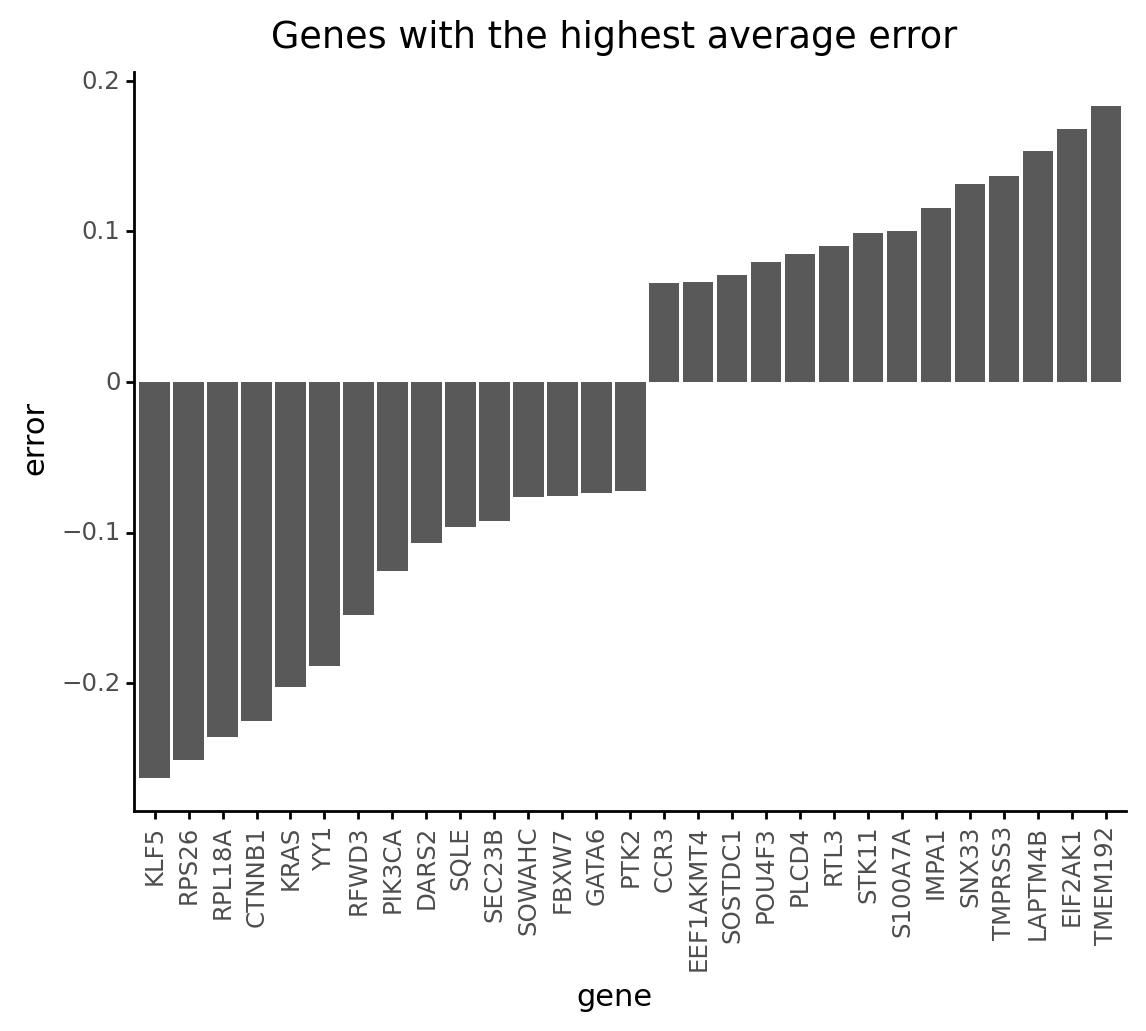

<ggplot: (2946456812207)>

In [27]:
gene_error = (
    pred_summary.groupby(["hugo_symbol"])["error"]
    .agg([np.mean, np.std])
    .reset_index(drop=False)
    .sort_values(["mean"])
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.astype(str),
            categories=d.hugo_symbol.astype(str),
            ordered=True,
        )
    )
)

n_genes = 15

(
    gg.ggplot(
        gene_error.iloc[list(range(n_genes)) + list(range(-n_genes, -1))],
        gg.aes(x="hugo_symbol", y="mean"),
    )
    + gg.geom_col()
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="gene", y="error", title="Genes with the highest average error")
)

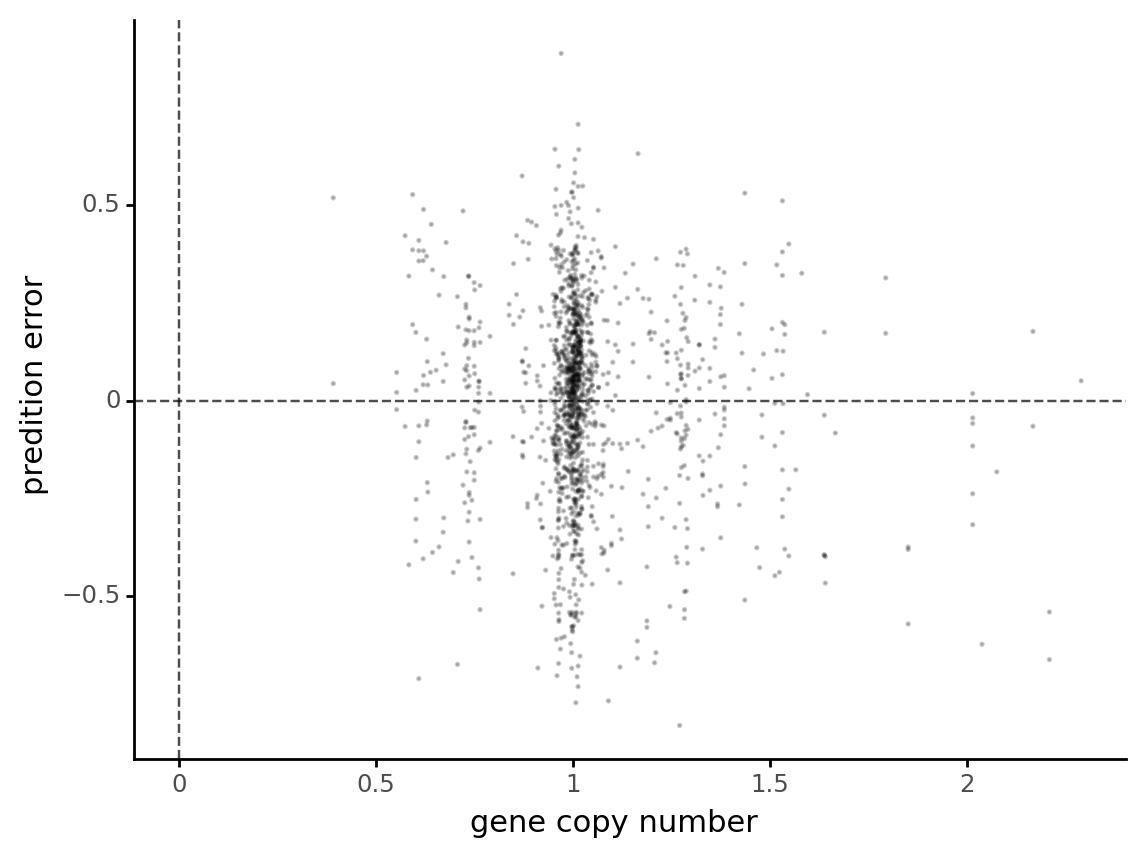

<ggplot: (2946452327768)>

In [28]:
(
    gg.ggplot(pred_summary, gg.aes(x="copy_number", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="gene copy number", y="predition error")
)

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.75 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-12

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-164.o2.rc.hms.harvard.edu

Git branch: fit-models

logging   : 0.5.1.2
plotnine  : 0.7.1
numpy     : 1.20.1
arviz     : 0.11.2
matplotlib: 3.3.4
pandas    : 1.2.3
pymc3     : 3.11.1
seaborn   : 0.11.1

